In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras

This implementation is based on this article [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.

#Custom Attention Layer

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. We will go with the latter option for this article. You can download the attention layer from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) and copy it in a different file called attention.py.

Let’s import it into our environment:

In [ ]:
from tensorflow.keras.layers import Attention

#Import the Libraries

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

#Read the dataset

This dataset consists of reddit post for various themes. These posts include various stories from various topic with a little summary.

We’ll take a sample of 200 posts to reduce the training time of our model. 

In [ ]:
#data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)
reddit100 = "/content/gdrive/MyDrive/UPM_ALUMNOS_2021/MasterThesis/reddit200_clean.csv"
data = pd.read_csv(reddit100, thousands  = ',',encoding='latin-1')
data.drop('subreddit', inplace=True, axis=1)
data.head()

,content,summary
0,"We actually did something very similar to this for our ""Senior Prank"" in high school. About 20 different kids chipped in $25-40 apiece. One of our classmate\'s father owns a party supply store. We...","High school prank, we dropped nearly 60,000 bouncy balls"
1,"Hello Reddit, \n I have been full of emotions lately and I just don\'t know how to explain it to myself anymore. \n For a bit of background, we have been together for 11 months and from that have ...","My boyfriend became so ""cold"" after being few months in a LDR - now I don\'t know if he lost the feelings for me or just became sure of me and comfortable."
2,"This is by far my favorite story to tell. I\'ve dubbed it ""The Uncle Bart Story"" \n So a couple years back, my friend had started college. He had graduated from high school being completely inexpe...","My friend's first girlfriend had a sugardaddy and he continued to be with her until she dumped him. \n Personally, I love this story because as my friend told me all of the events as they unfolded..."
3,"FAKE: blood makes up about 7% of the bodies mass. He weighs about 100kg, which is about 7kg of blood, or 7L. If he drank 750ml of 95% alcohol, it would be 712.5 ml of alcohol. which would put his ...","If real (which it is not) His BAC would be 10%, which is MANY time the highest ever seen."
4,"While it no doubt raises some eyebrows, it's not news that the person or persons who denied the Airmen will be reprimanded. The Armed Forces are predominately religiously affiliated, but that doe...","This was an exception, the Air Force wouldn't blatantly allow this expecting the media to not care about it. Especially with Mike Weinstein already breathing down their collective necks."


# Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['summary'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  200 non-null    object
 1   summary  200 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


#Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
cleaned_text = []
for t in data['content']:
    cleaned_text.append(text_cleaner(t,0)) 

Let us look at the first five preprocessed reviews

In [ ]:
cleaned_text[:5]  

['actually something similar senior prank high school different kids chipped apiece one classmate father owns party supply store purchased nearly small bouncy balls planned around rd period many kids came late would assure full participation kids stationed top stairwells others filled backpacks wore upside turned huge lake bouncy balls senior hallway kids started picking throwing war took minutes things settle random balls still found day lawn random cracks seemed like decent prank one hurt legal issues',
 'hello reddit full emotions lately know explain anymore bit background together months long distance months short visits enough money see back together country meet often met first time relationship really one neglecting sure wanted date always standing side spending free time knew wanted friendship always cared great friend eventually time passed grew feelings started dating things pretty amazing beginning never problems fell really deeply love never happier someone like time separa

In [ ]:
#call the function
cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [ ]:
cleaned_summary[:10]

['high school prank we dropped nearly bouncy balls',
 'my boyfriend became so cold after being few months in ldr now don know if he lost the feelings for me or just became sure of me and comfortable',
 'my friend first girlfriend had sugardaddy and he continued to be with her until she dumped him personally love this story because as my friend told me all of the events as they unfolded learned that love is not magic you should not blindly devote your entire life to someone that you hardly know sex is just the beginning of what could be meaningful relationship but the real essence of it is to know who you are with and be able to really understand why you are with them',
 'if real his bac would be which is many time the highest ever seen',
 'this was an exception the air force would not blatantly allow this expecting the media to not care about it especially with mike weinstein already breathing down their collective necks',
 'drunk schizo affective disorder patient freaks out over brac 

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

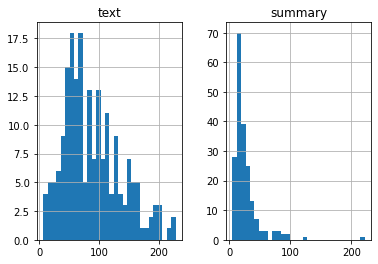

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 40 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.87


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [ ]:
max_text_len=512
max_summary_len= 40

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df

,text,summary
0,actually something similar senior prank high school different kids chipped apiece one classmate father owns party supply store purchased nearly small bouncy balls planned around rd period many kid...,sostok high school prank we dropped nearly bouncy balls eostok
1,hello reddit full emotions lately know explain anymore bit background together months long distance months short visits enough money see back together country meet often met first time relationshi...,sostok my boyfriend became so cold after being few months in ldr now don know if he lost the feelings for me or just became sure of me and comfortable eostok
2,fake blood makes bodies mass weighs kg kg blood drank ml alcohol would ml alcohol would put alcohol level times potentially lethal levels times much highest level ever recorded living human,sostok if real his bac would be which is many time the highest ever seen eostok
3,doubt raises eyebrows news person persons denied airmen reprimanded armed forces predominately religiously affiliated give right force plus old cadet mike weinstein really trying disrupt cosy atti...,sostok this was an exception the air force would not blatantly allow this expecting the media to not care about it especially with mike weinstein already breathing down their collective necks eostok
4,work last week patient known schizophrenic alcoholic asked anything drink completed brac test looks starts saying hate someone stole body using try find treasure ask found yet still looking reply ...,sostok drunk schizo affective disorder patient freaks out over brac test tells me her plan for world domination think eostok
...,...,...
169,throw away hoping someone advice gut wrenching nightmares whole life cannot take anymore topics range losing loved ones trapped maze like building handcuffed bubble sea trapped murky water acciden...,sostok have terrible nightmares to the point feel sore and shaken up in the morning and am afraid to go back to sleep eostok
170,withoyt seeing game hard really sure went wrong tbh cover basic things could problem lot things league absolutely meaningless unless translate win kill one going go ahead assume enemy similar lowe...,sostok if you win lane hard use the advantage to force objectives and win otherwise it means absolutely nothing eostok
171,looking advice cope new situation going breakup broke earlier month still stunned living together year dated three years long term relationship circumstances really hits hard moving week felt lone...,sostok she broke my heart still love her do not know what my next step is eostok
172,happen today much months ago nonetheless around time particular urban myth circulating among mates average girth erect peins roughly width standard toilet roll kind stupid urban myth nobody actual...,sostok played mythbusters and got my dick stuck in toilet roll eostok


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

#Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

#Text Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 2 which means word whose count is below 2 is considered as a rare word

In [ ]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 55.534441805225654
Total Coverage of rare words: 17.51442055584688


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with top most common words for reviews.

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

1873

#Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 92.6890756302521
Total Coverage of rare words: 47.38861020950132


Let us define the tokenizer with top most common words for summary.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let us check whether word count of start token is equal to length of the training data

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(156, 156)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
df

,text,summary
0,actually something similar senior prank high school different kids chipped apiece one classmate father owns party supply store purchased nearly small bouncy balls planned around rd period many kid...,sostok high school prank we dropped nearly bouncy balls eostok
1,hello reddit full emotions lately know explain anymore bit background together months long distance months short visits enough money see back together country meet often met first time relationshi...,sostok my boyfriend became so cold after being few months in ldr now don know if he lost the feelings for me or just became sure of me and comfortable eostok
2,fake blood makes bodies mass weighs kg kg blood drank ml alcohol would ml alcohol would put alcohol level times potentially lethal levels times much highest level ever recorded living human,sostok if real his bac would be which is many time the highest ever seen eostok
3,doubt raises eyebrows news person persons denied airmen reprimanded armed forces predominately religiously affiliated give right force plus old cadet mike weinstein really trying disrupt cosy atti...,sostok this was an exception the air force would not blatantly allow this expecting the media to not care about it especially with mike weinstein already breathing down their collective necks eostok
4,work last week patient known schizophrenic alcoholic asked anything drink completed brac test looks starts saying hate someone stole body using try find treasure ask found yet still looking reply ...,sostok drunk schizo affective disorder patient freaks out over brac test tells me her plan for world domination think eostok
...,...,...
169,throw away hoping someone advice gut wrenching nightmares whole life cannot take anymore topics range losing loved ones trapped maze like building handcuffed bubble sea trapped murky water acciden...,sostok have terrible nightmares to the point feel sore and shaken up in the morning and am afraid to go back to sleep eostok
170,withoyt seeing game hard really sure went wrong tbh cover basic things could problem lot things league absolutely meaningless unless translate win kill one going go ahead assume enemy similar lowe...,sostok if you win lane hard use the advantage to force objectives and win otherwise it means absolutely nothing eostok
171,looking advice cope new situation going breakup broke earlier month still stunned living together year dated three years long term relationship circumstances really hits hard moving week felt lone...,sostok she broke my heart still love her do not know what my next step is eostok
172,happen today much months ago nonetheless around time particular urban myth circulating among mates average girth erect peins roughly width standard toilet roll kind stupid urban myth nobody actual...,sostok played mythbusters and got my dick stuck in toilet roll eostok


# Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 512, 100)     187300      input_6[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 512, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=5, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/100
31/31 [==============================] - 478s 15s/step - loss: 1.5633 - val_loss: 1.0831
Epoch 2/100
31/31 [==============================] - 488s 16s/step - loss: 1.1816 - val_loss: 0.9967
Epoch 3/100
31/31 [==============================] - 498s 16s/step - loss: 1.1289 - val_loss: 0.9563
Epoch 4/100
31/31 [==============================] - 485s 16s/step - loss: 1.0741 - val_loss: 0.9493
Epoch 5/100
31/31 [==============================] - 478s 15s/step - loss: 1.0601 - val_loss: 0.9482
Epoch 6/100
31/31 [==============================] - 472s 15s/step - loss: 1.0489 - val_loss: 0.9381
Epoch 7/100
31/31 [==============================] - 468s 15s/step - loss: 1.0370 - val_loss: 0.9523
Epoch 8/100
31/31 [==============================] - 466s 15s/step - loss: 1.0321 - val_loss: 0.9637
Epoch 00008: early stopping


#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

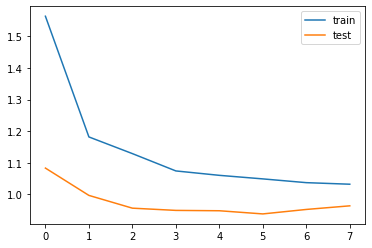

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 41 for 2 successive epochs. Hence, training is stopped at epoch 43.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index



# Inference

Set up the inference for the encoder and decoder:

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if (sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[0].reshape(1,max_text_len)))
    print("\n")

Review: hello reddit relatively new whole relationship thing sure behave certain situations girlfriend dating months went shopping nice day later asked via text want watch movie tomorrow today got text sorry appointment dad watch movie asked would pissed would nnow know big deal best way react say totally cool say little pissed actually first time something like happen wondering little answers 
Original summary: my on me and just want to know how to 
Predicted summary:  if to to and and the the the the it to to


Review: disparagement memory deceased persons memory deceased person punished two years fine nif memory deceased person file complaint act writings making complaint required deceased person lost life another rule force disparagement connected 
Original summary: of of the is 
Predicted summary:  if to to and and the the the the it to to


Review: graves would lose maybe cost even anymore aside 
Original summary: not 
Predicted summary:  if to to and and the the the the it to to